# `Wikispeedia` Data Exploration and Processing

This `Jupyter notebook` contains the code and rationale behind the data processing we have done. It is split into 3 sections:

1. `Hyperlinks' Click Preferences`: extracting hyperlinks in image captions and their position in an article
2. `Document Similarity`: measuring document similarity between Wikipedia articles
3. `Graph Topology`: exploring the graph topology of navigation paths

**Note:** One important change we make to the dataset is we do not consider navigation paths where the participant "back tracks". `Doing so removes exactly 8995/51318 successful paths and 5201/24875 unsuccessful paths.` While a considerable amount, the action of "back tracking" adds complexity to our document similarity and graph topology analyses. For example, we would need a method to handle measures of document similarity if a user "back tracks" and thus visits two out-links from the parent article; do we track both similarities? In our graph topology analysis, how do we handle the "flow" of hyperlinks when one can move backwards? By removing these navigation paths, we form a `Matched Study` such that our analysis holds for all `Unidirectional Navigation Paths` (not necessarily linear if there exists paths where a user navigates back to a previous article).

## 1. Hyperlinks' Click Preferences

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse

In [2]:
# extract html files
wp_path = "../Wikispeedia/wpcd/wp/" # change path accordingly
# get all sub-directories
directories = os.listdir(wp_path)
html_list = []
for sub_dir in directories:
    sub_dir_contents = os.listdir(os.path.join(wp_path, sub_dir))
    for file in sub_dir_contents:
        if file[-3:]=='htm':
            html_list.append(os.path.join(sub_dir, file))
            
# show some of the extracted html files
html_list[:3]

['r/Royal_Marines.htm',
 'r/Recycling.htm',
 'r/Retreat_of_glaciers_since_1850.htm']

### Objective

The aim of this specific game strategy analysis is to test whether `Wikispeedia` players have clikability preferences on the basis of the hyperlinks' positioning throughout the article text. 

In particular, we will:
1. find the ordinal number of the paragraph each hyperlink in an article shows up in and divide it by the total number of paragraphs of the article, to determine its relative positioning
2. determine if each hyperlink in an article shows up in an image caption.

We will then investigate if there is a correlation between the click preferences of hyperlinks based on their position, using proper statistical tests. 

### Hyperlinks positioning in articles' text

It is essential to extract from the data the frequency of clicks for each hyperlink.

In [3]:
# read files 
parent_folder_path='../Wikispeedia/wikispeedia_paths-and-graph/'

# create the DataFrames
paths_finished_df=(pd.read_csv(os.path.join(parent_folder_path, 'paths_finished.tsv'), 
                               sep='\t', skiprows=15, header=None)
                   .rename(columns={0:"ip",
                                    1:"timestamp",
                                    2:"duration",
                                    3:"path",
                                    4:"rating"}))

paths_unfinished_df=(pd.read_csv(os.path.join(parent_folder_path, 'paths_unfinished.tsv'), 
                               sep='\t', skiprows=16, header=None)
                     .rename(columns={0:"ip",
                                      1:"timestamp",
                                      2:"duration",
                                      3:"path",
                                      4:"target",
                                      5:"type"}))

articles_df=pd.read_csv(os.path.join(parent_folder_path, 'articles.tsv'), 
                        sep='\t', skiprows=12, header=None, names=['article'])

The dataframe `paths_finished_df` contains the paths chosen by the players who could reach the target article.

In [4]:
paths_finished_df.head()

,ip,timestamp,duration,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


The dataframe `paths_unfinished` contains the paths chosen by the players who could not reach the target article.

In [5]:
paths_unfinished_df.head()

,ip,timestamp,duration,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


The dataframe `articles_df` lists all the clickable articles/links.

In [6]:
# encode and filter link names
def filter_link_list(links_list):
    new_links_list=[]
    
    for link in links_list:
        link=urllib.parse.unquote(link).lower().replace('_', '').strip()
        new_links_list.append(link)
        
    return new_links_list

articles_df.article=filter_link_list(articles_df.article)
articles_df.head()

,article
0,áedánmacgabráin
1,åland
2,édouardmanet
3,éire
4,óengusiofthepicts


In [7]:
print('The total number of articles comprising the Wikispeedia library is {0}.'.format(len(articles_df)))

The total number of articles comprising the Wikispeedia library is 4604.


The dataframe `clicked_links_filtered` contains the clicked links throughout the paths.

In [8]:
clicked_links=[path.split(';') for path in paths_finished_df['path']]

clicked_links_filtered=[] # consistent with other dfs
for path in clicked_links:
    # remove navigation paths that "back track"
    if '<' in path:
        continue
    else:
        path_filtered=filter_link_list(path)
        clicked_links_filtered.append(path_filtered)

clicked_links_filtered[:2]

[['14thcentury',
  '15thcentury',
  '16thcentury',
  'pacificocean',
  'atlanticocean',
  'accra',
  'africa',
  'atlanticslavetrade',
  'africanslavetrade'],
 ['14thcentury',
  'europe',
  'africa',
  'atlanticslavetrade',
  'africanslavetrade']]

The dataframe `links_freq_df` contains the links' frequency of clicks.

In [9]:
links_name=[]
links_freq=[]

for article in articles_df.article: # count the number of times each article shows up in paths
    count=0
    links_name.append(article)
    for i in range(len(clicked_links_filtered)):
        # do not count the first article since that's the start
        if article in clicked_links_filtered[i][1:]:
            count+=1 
    links_freq.append(count)

links_name=pd.Series(links_name)
links_freq=pd.Series(links_freq)
links_freq_df=pd.concat([links_name, links_freq], axis=1, names=['link', '#_clicks'])
links_freq_df.columns=['link', '#_clicks']

links_freq_df.loc[links_freq_df['#_clicks']!=0].head()

,link,#_clicks
1,åland,1
2,édouardmanet,1
3,éire,1
6,10thcentury,57
7,11thcentury,69


In [10]:
clicks_tot=links_freq_df['#_clicks'].sum()
print('The total number of clicked hyperlinks is {0}.'.format(clicks_tot))

The total number of clicked hyperlinks is 199336.


Next step of the descriptive analysis process is the html files parsing aimed at determining the location of hyperlinks. 

In [11]:
# parse html files 

from bs4 import BeautifulSoup

soups=[]
failed_html_list = []
for html in html_list[:]:
    f=open(wp_path+html, 'r')
    try:
        soup = BeautifulSoup(f, 'lxml')
        soups.append(soup)
    except Exception:
        failed_html_list.append(html)

In [12]:
print('{0} files were not parsable. However, they are not reachable nor it is possible to click \
any hyperlink in those html pages.'.format(len(failed_html_list)))

53 files were not parsable. However, they are not reachable nor it is possible to click any hyperlink in those html pages.


`link_positioning_dfs` is a list of dataframes (`link_positioning_df`) containing hyperlinks showing up in one html file, the ordinal number of the paragraph they belong to and their relative positioning throughout the article text. 

In [13]:
# HTML tag for hyperlinks is <a href= >
# the function finds all <a href= > tags throughout the article html file

def find_links(soup): 
    paragraphs = soup.find_all('p') 
    links=[]

    for i, p in enumerate(paragraphs):
        i+=1
        all_links=p.find_all('a')
        for link in all_links:
            if 'href' in link.attrs:
                link_title=link.text
                link_paragraph=i
                links.append([link_title, link_paragraph])
                
    link_positioning_df=pd.DataFrame(links, columns=['link', '#_paragraph']).drop_duplicates()
    link_positioning_df['positioning']=round(link_positioning_df['#_paragraph']/len(paragraphs), 2)
    link_positioning_df['link']=filter_link_list(link_positioning_df['link'])
    return link_positioning_df

In [14]:
# apply the function to all html files

link_positioning_dfs=[]
for soup in soups:
    link_positioning_dfs.append(find_links(soup))

link_positioning_dfs[:2]

[                              link  #_paragraph  positioning
 0                       royal navy            1         0.01
 1                   united kingdom            1         0.01
 2                         cold war           18         0.19
 3                     sierra leone           20         0.21
 4                         dartmoor           24         0.25
 5                     world war ii           29         0.30
 6                         plymouth           34         0.35
 7                         scotland           34         0.35
 8                        gibraltar           43         0.44
 9                             cuba           44         0.45
 10               george washington           44         0.45
 11                      royal navy           45         0.46
 13                      portsmouth           46         0.47
 14                        plymouth           46         0.47
 15      american revolutionary war           46         0.47
 16     

In [15]:
print(f'{len(link_positioning_dfs)} html files were parsed.')

5409 html files were parsed.


In [16]:
# example with 2 files

PATH_1 = os.path.join(wp_path, 'a/A_cappella.htm')
PATH_2 = os.path.join(wp_path, 'm/Music.htm')

f1=open(PATH_1, 'r')
soup1 = BeautifulSoup(f1, 'lxml')

f2=open(PATH_2, 'r')
soup2 = BeautifulSoup(f2, 'lxml')

link_positioning_df_1=find_links(soup1).drop(labels='#_paragraph', axis=1)
link_positioning_df_2=find_links(soup2).drop(labels='#_paragraph', axis=1)

# merging the 2 dataframes 

merged_dfs=link_positioning_df_1.merge(link_positioning_df_2, how='outer', left_on='link', right_on='link', )
merged_dfs

,link,positioning_x,positioning_y
0,music,0.04,NaN
1,instrumental,0.04,NaN
2,renaissance,0.04,NaN
3,renaissance,0.12,NaN
4,gregorian chant,0.12,NaN
5,amish,0.21,NaN
6,eastern orthodox,0.21,NaN
7,jewish,0.33,NaN
8,beatles,0.75,NaN
9,hindi,0.88,NaN


The hyperlink `rap` shows up in both articles; the hyperlink `jazz`, `renaissance` and `time` show up multiple times in one article. 

The two occurrences highlighted are likely to be the case for every hyperlink, when all dataframes will be merged. It is therefore essential to compute their most likely positioning in the articles' texts to extract any meaningful information from the data.  

In [17]:
# merge all the link_positioning_df in link_positioning_dfs list on hyperlink in order to apply a function 
# that determines the most frequent positioning of the hyperlinks


link_positioning_dfs_grouped=[]

fail=0  
for i, df in enumerate(link_positioning_dfs):
    try:
        df=df.set_index("link")
        df=df["positioning"].groupby("link").apply(lambda x: x.values).rename(f"article_{i}")
        link_positioning_dfs_grouped.append(df)
    except:
        fail+=1
        pass 

from itertools import chain
link_positioning_concatenated=(pd.concat(link_positioning_dfs_grouped)
                               .groupby("link")
                               .apply(lambda x: list(chain(*x.values))))
link_positioning_concatenated[:10]

link
                                [0.78, 0.8, 0.84, 0.85, 0.87, 0.89, 0.91, 0.93...
"6 villages for 2006                                                       [0.67]
"6 villages for 2006"                                                [0.36, 0.46]
"capitalist rule"                                                          [0.16]
"consumption" (tuberculosis)                                               [0.03]
"glorious revolution"                                                      [0.39]
"grave"                                                                    [0.31]
"law of queen anne"                                                        [0.52]
"name and anagram"                                                          [0.1]
"nostalgic tram" no. 91                                                    [0.76]
dtype: object

In [18]:
# function that determines the most frequent positioning of each hyperlink in the set of all links

def find_positioning(array):
    bin_labels=['top', 'center-top','center','center-bottom', 'bottom'] # positioning is classified as top, centre-top, center, center-bottom, or bottom of the article
    bins=[0, 0.20, 0.40, 0.60, 0.80, 1] 
    cut_positioning=pd.cut(array, bins, labels=bin_labels, right=True, include_lowest=True)
    positioning_frequency=pd.value_counts(cut_positioning) # frequency of the bins
    most=positioning_frequency.apply('max') # bin with highest frequency
    if len(positioning_frequency[positioning_frequency==most])>1:
        return np.random.choice(positioning_frequency[positioning_frequency==most].index.values.astype(str)) #account for same frequency
    else:
        return positioning_frequency[positioning_frequency==most].index.values.astype(str).item()

The dataframe `most_freq_positioning_df` contains the hyperlinks' most frequent positioning.

In [19]:
# all html files

most_freq_positioning=link_positioning_concatenated.apply(find_positioning)
most_freq_positioning_df=pd.DataFrame(most_freq_positioning, columns=['most_freq_positioning'])[1:]
most_freq_positioning_df.reset_index()

,link,most_freq_positioning
0,"""6 villages for 2006",center-bottom
1,"""6 villages for 2006""",center
2,"""capitalist rule""",top
3,"""consumption"" (tuberculosis)",top
4,"""glorious revolution""",center-top
...,...,...
10527,‘6 villages for 2006’,center-bottom
10528,“6 villages for 2006”,center
10529,€,center-bottom
10530,€25 million,top


The dataframe `links_freq_pos` contains both the hyperlinks' most frequent positioning and their frequency of clicks.

In [20]:
links_freq_pos=links_freq_df.merge(most_freq_positioning_df, how='outer', left_on='link', right_on='link')
links_freq_pos

,link,#_clicks,most_freq_positioning
0,áedánmacgabráin,0.0,NaN
1,åland,1.0,bottom
2,édouardmanet,1.0,NaN
3,éire,1.0,top
4,óengusiofthepicts,0.0,NaN
...,...,...,...
13525,‘6 villages for 2006’,NaN,center-bottom
13526,“6 villages for 2006”,NaN,center
13527,€,NaN,center-bottom
13528,€25 million,NaN,top


In [21]:
not_clicked=links_freq_pos['#_clicks'].isnull().value_counts()[0]
print('There are {0} links in the articles, {1} never clicked.'.format(len(most_freq_positioning_df), not_clicked))

There are 10532 links in the articles, 4604 never clicked.


The dataframe `links_freq_pos_grouped_df` groups the hyperlinks click frequency by their positioning.

In [22]:
links_freq_pos_grouped=links_freq_pos['#_clicks'].groupby(links_freq_pos['most_freq_positioning']).sum()
links_freq_pos_grouped_df=pd.DataFrame(links_freq_pos_grouped)
links_freq_pos_grouped_df['#_clicks_norm']=links_freq_pos_grouped_df['#_clicks']/clicks_tot #normalization
links_freq_pos_grouped_df

,#_clicks,#_clicks_norm
most_freq_positioning,,
bottom,10770.0,0.054029
center,3957.0,0.019851
center-bottom,4386.0,0.022003
center-top,8510.0,0.042692
top,89712.0,0.450054


In order to compare the hyperlinks click frequencies with regard to their positioning (i.e. _top_, _center-top_, _center_, _center-bottom_, _bottom_) their absolute values need to be normalized with the bins' frequencies (i.e. the number of times the hypelinks actually show up in the categorical positioning).

The dataframe `positioning_freq_df_grouped` contains the frequency of hyperlinks showing up in the `Wikispeedia` set of articles grouped by their positioning throughout the text. 

In [23]:
# function that counts the frequency of a link showing up at the top, center, bottom of the article

def find_positioning_dis(array):
    bin_labels=['top', 'center-top','center', 'center-bottom', 'bottom']
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1]
    cut_positioning=pd.cut(array, bins, labels=bin_labels, right=True, include_lowest=True)
    positioning_frequency=pd.value_counts(cut_positioning)
    return positioning_frequency

In [24]:
# apply the function to the dataframe links positioning grouped by link  

positioning_freq=link_positioning_concatenated.apply(find_positioning_dis)
positioning_freq

,bottom,top,center-bottom,center,center-top
link,,,,,
,220,130,45,42,33
"""6 villages for 2006",0,0,1,0,0
"""6 villages for 2006""",0,0,0,1,1
"""capitalist rule""",0,1,0,0,0
"""consumption"" (tuberculosis)",0,1,0,0,0
...,...,...,...,...,...
‘6 villages for 2006’,0,0,1,0,1
“6 villages for 2006”,0,0,0,1,0
€,2,2,6,3,4


In [25]:
positioning_freq_grouped=positioning_freq.sum(axis=0) # group by positioning
positioning_freq_grouped_df=pd.DataFrame(positioning_freq_grouped, columns=['nr'])
links_tot=positioning_freq_grouped_df['nr'].sum()
positioning_freq_grouped_df['nr_norm']=positioning_freq_grouped_df['nr']/links_tot
positioning_freq_grouped_df

,nr,nr_norm
bottom,24193,0.184871
top,40824,0.311957
center-bottom,22588,0.172607
center,20228,0.154573
center-top,23031,0.175992


In [26]:
vis=links_freq_pos_grouped_df.merge(positioning_freq_grouped_df, left_index=True, right_index=True)
vis

,#_clicks,#_clicks_norm,nr,nr_norm
bottom,10770.0,0.054029,24193,0.184871
center,3957.0,0.019851,20228,0.154573
center-bottom,4386.0,0.022003,22588,0.172607
center-top,8510.0,0.042692,23031,0.175992
top,89712.0,0.450054,40824,0.311957


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '#_clicks / #_hyperlinks')

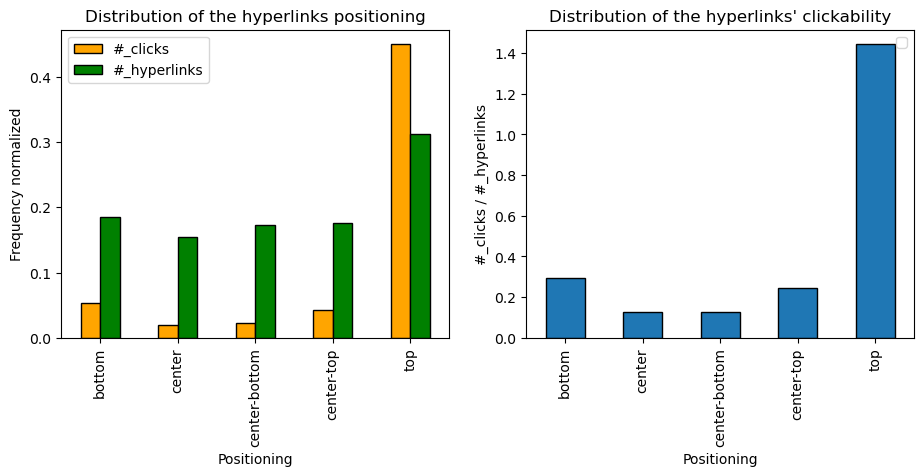

In [27]:
# visualization of the distribution of the clicked hyperlinks' positioning

# dataframe for visualization
vis=links_freq_pos_grouped_df.merge(positioning_freq_grouped_df, left_index=True, right_index=True)

fig, ax = plt.subplots(1,2, figsize=(11,4))
vis.plot(y=['#_clicks_norm', 'nr_norm'],
         kind='bar', ax=ax[0], 
         label=['#_clicks', '#_hyperlinks'], 
         color=['orange', 'green'],
         edgecolor=['k', 'k'])
ax[0].legend()
ax[0].set_title('Distribution of the hyperlinks positioning')
ax[0].set_xlabel('Positioning')
ax[0].set_ylabel('Frequency normalized')

vis['clicked']=vis['#_clicks_norm']/vis['nr_norm'] # not sure
vis.plot(y='clicked', 
         kind='bar', 
         ax=ax[1], 
         label='',
         edgecolor='k')
ax[1].legend()
ax[1].set_title("Distribution of the hyperlinks' clickability")
ax[1].set_xlabel('Positioning')
ax[1].set_ylabel('#_clicks / #_hyperlinks')

The bar plot on the left illustrates the distribution of the clicked hyperlinks and the total number of links in the articles, on the basis of their positioning throughout the articles text, both normalized. 

The bar plot on the right illustrates the hyperlinks clickability on the basis of their positioning. More precisely: 
1. a value of 1 (_\#_clicks_/_\#_hyperlinks_ = 1) corresponds to a hyperlinks clickability on average equally proportional to the normalized frequency of the specific categorical positioning (i.e. the number of clicks proportional to the number times a hyperlink shows up in a section of the article);
2. a value of greater than 1, points a more than proportional clickability;
3. a value of smaller than 1, points a less than proportional clickability.

### Hyperlinks positioning in images' caption

The following part of the descriptive analysis focuses on the location of hyperlinks in images' captions.

Images in html files can be either found under \<div> or \<table> tag, while the hyperlinks are found in their captions under \<div class='thumbcaption'> tag.

The dataframe `links_in_tables` contains the links showing up in tables' captions. 

In [28]:
# parse html file and search hyperlinks in the captions of tables containing images 

def find_link_in_table(soup):
    
    tables = soup.find_all('table')

    links=[]
    for table in tables:
        if table.find('img'):
            all_links=table.find_all('a')
            for link in all_links:
                if 'class' not in link.attrs:
                    link_title=link.text
                    links.append(link_title)

    if links:
        links_in_table_df=pd.DataFrame(links).drop_duplicates()
        links_in_table_df.columns=['link']
        links_in_table_df=links_in_table_df.apply(filter_link_list) 
    else: 
        return None
    return links_in_table_df

In [29]:
links_in_tables=[]
for soup in soups:
    links_in_tables.append(find_link_in_table(soup))

links_in_tables_df=pd.concat(links_in_tables, axis=0)
links_in_tables_df.head()

,link
0,royal navy
1,united kingdom
3,plymouth
4,latin
0,lawrencium


In [30]:
links_in_tables_tot=len(links_in_tables_df)
print('The total number of links in tables captions is {0}.'.format(links_in_tables_tot))

The total number of links in tables captions is 15159.


The dataframe `links_in_images` contains the links showing up in images' captions.

In [31]:
# parse html file and search hyperlinks in the captions of div containing images 

def find_links_in_img(soup):
    div = soup.find_all('div')

    links=[]

    for d in div:
        if (d.find('a', class_="internal")):
            if (d.find('img', class_='thumbimage')):
                caption=d.find('div', class_="thumbcaption")
                if (caption.find('a')):
                    all_links=caption.find_all('a')
                    for link in all_links:
                        if 'class' not in link.attrs:
                            link_title=link.text
                            links.append(link_title)
    if links:
        links_in_image_df=pd.DataFrame(links).drop_duplicates()
        links_in_image_df.columns=['link']
        links_in_image_df=links_in_image_df.apply(filter_link_list) 
    else: 
        return None
        links_in_image_df=pd.DataFrame()
    return links_in_image_df

In [32]:
links_in_images=[]
for soup in soups:
    links_in_images.append(find_links_in_img(soup))


links_in_images_df=pd.concat(links_in_images, axis=0)
links_in_images_df.head()

,link
0,bangladesh
0,portsmouth
2,england
4,india
0,pompeii


In [33]:
links_in_images_tot=len(links_in_images_df)
print('The total number of links in images captions is {0}.'.format(links_in_images_tot))

The total number of links in images captions is 372.


Next, the supposed clickability preference for a hyperlink showing up in an image will be investigated, by grouping the click frequency by hyperlinks' location.

In [34]:
# drop indexes to ease the flagging
links_in_images_df=links_in_images_df.reset_index(drop=True)
links_in_tables_df=links_in_tables_df.reset_index(drop=True)

In [35]:
links_freq_df

,link,#_clicks
0,áedánmacgabráin,0
1,åland,1
2,édouardmanet,1
3,éire,1
4,óengusiofthepicts,0
...,...,...
4599,zionism,13
4600,zirconium,18
4601,zoroaster,6
4602,zuid-gelders,4


The dataframe `links_freq_img` contains hyperlinks click frequency and a flag specifying if they can be found in images' captions.

In [36]:
# link in image

flag_img=[]
links_freq_img=links_freq_df.copy()

for link in links_freq_img['link']:
    if link in list(links_in_images_df['link']):
        flag_img.append(1)
    else:
        flag_img.append(0)
    
links_freq_img['in_image']=flag_img
links_freq_img[links_freq_img['in_image']==1][:10]

,link,#_clicks,in_image
1,åland,1,1
145,agamemnon,14,1
156,akbar,0,1
197,allah,35,1
232,amsterdam,62,1
373,athens,184,1
392,augustus,19,1
393,australia,770,1
455,bangladesh,29,1
466,barcelona,36,1


In [37]:
# link in image

flag_img=[]
links_freq_img=links_freq_df.copy()

for link in links_freq_img['link']:
    if link in list(links_in_images_df['link']):
        flag_img.append(1)
    else:
        flag_img.append(0)
    
links_freq_img['in_image']=flag_img
links_freq_img[links_freq_img['in_image']==1][:10]

,link,#_clicks,in_image
1,åland,1,1
145,agamemnon,14,1
156,akbar,0,1
197,allah,35,1
232,amsterdam,62,1
373,athens,184,1
392,augustus,19,1
393,australia,770,1
455,bangladesh,29,1
466,barcelona,36,1


The dataframe `links_freq_tab` contains hyperlinks click frequency and a flag specifying if they can be found in tables' captions.

In [38]:
# link in table

flag_tab=[]
links_freq_tab=links_freq_df.copy()

for link in links_freq_tab['link']:
    if link in list(links_in_tables_df['link']):
        flag_tab.append(1)
    else:
        flag_tab.append(0)
    
links_freq_tab['in_tab']=flag_tab
links_freq_tab[links_freq_tab['in_tab']==1][:10]

,link,#_clicks,in_tab
1,åland,1,1
43,4-2-0,0,1
66,aids,153,1
89,aberdeen,13,1
91,aberystwyth,7,1
93,abidjan,6,1
94,abkhazia,4,1
102,abuja,10,1
105,accra,10,1
107,acetone,2,1


In [39]:
# find normalized values of clicks (#_clicks) on the basis of the relative number of times a hyperlink shows up in an 
# image caption to occurrence in the article text 

# images 

links_in_img=pd.concat(links_in_images, axis=0).reset_index(drop=True)

link_in_img_freq=[]
link_name=[]

for link in list(links_in_img['link']):
    count=list(links_in_img['link']).count(link)
    link_name.append(link)
    link_in_img_freq.append(count)

link_name=pd.Series(link_name)
link_in_img_freq=pd.Series(link_in_img_freq)
link_in_img_freq_df=pd.concat([link_name, link_in_img_freq], axis=1)
link_in_img_freq_df.columns=['link', '#_link_in_img']
link_in_img_freq_df

,link,#_link_in_img
0,bangladesh,1
1,portsmouth,1
2,england,4
3,india,4
4,pompeii,1
...,...,...
367,germany,1
368,albrecht dürer,2
369,sculptures,1
370,europe,1


In [40]:
# links showing up in images' captions and also in texts

links_in_text=pd.concat(link_positioning_dfs, axis=0)['link']
link_in_text_freq=[]
link_name=[]

for link in list(links_in_img['link']):
    count=list(links_in_text).count(link)
    link_name.append(link)
    link_in_text_freq.append(count)

link_name_text=pd.Series(link_name)
link_in_text_freq=pd.Series(link_in_text_freq)
link_in_text_freq_df=pd.concat([link_name_text, link_in_text_freq], axis=1)
link_in_text_freq_df.columns=['link', '#_link_in_text']
link_in_text_freq_df

,link,#_link_in_text
0,bangladesh,100
1,portsmouth,25
2,england,635
3,india,667
4,pompeii,19
...,...,...
367,germany,634
368,albrecht dürer,14
369,sculptures,4
370,europe,780


In [41]:
df_img=pd.merge(links_freq_img[links_freq_img['in_image']==1], link_in_img_freq_df, left_on='link', right_on='link')
new_df_img=pd.merge(df_img, link_in_text_freq_df, left_on='link', right_on='link')
new_df_img=new_df_img.set_index('link')
new_df_img

,#_clicks,in_image,#_link_in_img,#_link_in_text
link,,,,
åland,1,1,1,4
agamemnon,14,1,1,14
akbar,0,1,1,9
allah,35,1,1,17
amsterdam,62,1,1,57
...,...,...,...,...
warsaw,41,1,3,37
warsaw,41,1,3,37
warsaw,41,1,3,37


In [42]:
norm_values_img=new_df_img['#_link_in_img']/new_df_img['#_link_in_text']
clicks_norm_img=(new_df_img['#_clicks']*norm_values_img)
clicks_norm_img.replace([np.inf, -np.inf], np.nan, inplace=True)
clicks_norm_img=clicks_norm_img.fillna(0).values.astype('int')

In [43]:
links_freq_img=links_freq_img.set_index('link')
links_freq_img.rename(columns={'#_clicks':'#_clicks_norm'}, inplace=True)
links_freq_img.loc[norm_values_img.index,'#_clicks_norm']=clicks_norm_img
links_freq_img

,#_clicks_norm,in_image
link,,
áedánmacgabráin,0,0
åland,0,1
édouardmanet,1,0
éire,1,0
óengusiofthepicts,0,0
...,...,...
zionism,13,0
zirconium,18,0
zoroaster,6,0


In [44]:
# tables 

links_in_tab=pd.concat(links_in_tables, axis=0).reset_index(drop=True)

link_in_tab_freq=[]
link_name=[]

for link in list(links_in_tab['link']):
    count=list(links_in_tab['link']).count(link)
    link_name.append(link)
    link_in_tab_freq.append(count)

link_name=pd.Series(link_name)
link_in_tab_freq=pd.Series(link_in_tab_freq)
link_in_tab_freq_df=pd.concat([link_name, link_in_tab_freq], axis=1)
link_in_tab_freq_df.columns=['link', '#_link_in_tab']

In [45]:
links_in_text=pd.concat(link_positioning_dfs, axis=0)['link']
link_in_text_freq=[]
link_name=[]

for link in list(links_in_tab['link']):
    count=list(links_in_text).count(link)
    link_name.append(link)
    link_in_text_freq.append(count)

link_name_text=pd.Series(link_name)
link_in_text_freq=pd.Series(link_in_text_freq)
link_in_text_freq_df=pd.concat([link_name_text, link_in_text_freq], axis=1)
link_in_text_freq_df.columns=['link', '#_link_in_text']

In [46]:
df_tab=pd.merge(links_freq_tab[links_freq_tab['in_tab']==1], link_in_tab_freq_df, left_on='link', right_on='link')
new_df_tab=pd.merge(df_tab, link_in_text_freq_df, left_on='link', right_on='link')
new_df_tab=new_df_tab.set_index('link')

norm_values_tab=new_df_tab['#_link_in_tab']/new_df_tab['#_link_in_text']
clicks_norm_tab=(new_df_tab['#_clicks']*norm_values_tab)
clicks_norm_tab.replace([np.inf, -np.inf], np.nan, inplace=True)
clicks_norm_tab=clicks_norm_tab.fillna(0).values.astype('int')

links_freq_tab=links_freq_tab.set_index('link')
links_freq_tab.rename(columns={'#_clicks':'#_clicks_norm'}, inplace=True)
links_freq_tab.loc[norm_values_tab.index,'#_clicks_norm']=clicks_norm_tab
links_freq_tab

,#_clicks_norm,in_tab
link,,
áedánmacgabráin,0,0
åland,0,1
édouardmanet,1,0
éire,1,0
óengusiofthepicts,0,0
...,...,...
zionism,1,1
zirconium,3,1
zoroaster,6,0


The dataframe `links_freq_img_grouped_df` contains the frequency of clicks for hyperlinks showing up in images' captions and not, and their normalized values.

In [47]:
links_freq_img_grouped_df=pd.DataFrame(links_freq_img['#_clicks_norm'].groupby(links_freq_img['in_image']).sum())

links_freq_img_grouped_df.loc[0,'#_clicks/#_links_img']=links_freq_img_grouped_df.loc[0,'#_clicks_norm']/(links_tot-links_in_images_tot)
links_freq_img_grouped_df.loc[1,'#_clicks/#_links_img']=links_freq_img_grouped_df.loc[1,'#_clicks_norm']/links_in_images_tot

links_freq_img_grouped_df

,#_clicks_norm,#_clicks/#_links_img
in_image,,
0,172829,1.324441
1,186,0.500000


The dataframe `links_freq_tab_grouped_df` contains the frequency of clicks for hyperlinks showing up in tables' captions and not, and their normalized values.

In [48]:
links_freq_tab_grouped_df=pd.DataFrame(links_freq_tab['#_clicks_norm'].groupby(links_freq_tab['in_tab']).sum())

links_freq_tab_grouped_df.loc[0,'#_clicks/#_links_tab']=links_freq_tab_grouped_df.loc[0,'#_clicks_norm']/(links_tot-links_in_tables_tot)
links_freq_tab_grouped_df.loc[1,'#_clicks/#_links_tab']=links_freq_tab_grouped_df.loc[1,'#_clicks_norm']/links_in_tables_tot

links_freq_tab_grouped_df

,#_clicks_norm,#_clicks/#_links_tab
in_tab,,
0,122487,1.058615
1,10047,0.662775


Text(0.5, 1.0, 'Clicability of hyperlinks in captions')

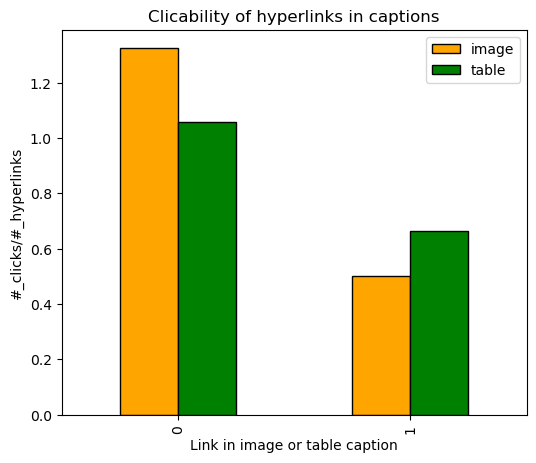

In [49]:
# dataframe for visualization
vis_img=links_freq_img_grouped_df.merge(links_freq_tab_grouped_df, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(6,5))
vis_img.plot(y=['#_clicks/#_links_img', '#_clicks/#_links_tab'], 
             kind='bar', 
             ax=ax, label=['image', 'table'], 
             color=['orange', 'green'], edgecolor='k')
ax.legend()
ax.set_xlabel('Link in image or table caption')
ax.set_ylabel('#_clicks/#_hyperlinks')
ax.set_title('Clicability of hyperlinks in captions')

Assumptions: 
1. when a hyperlink shows up in both the article text and in an image caption, it is not possible to extract from the data the player's click choice. Therefore we assumed that hyperlinks showing up in images' captions don't appear in the text, as the following statement justifies. The normalization, therefore took into account a total number of links in texts equal to  (total number of hyperlinks detected) - (total number of hyperlinks showing up in images' captions). 

In [50]:
twice=0
for idx in range(len(link_positioning_dfs)):
    if links_in_images[idx] is None:
        continue
    else:
        if set(link_positioning_dfs[idx]['link']).intersection(set(links_in_images[idx]['link'])):
            twice+=1
print('{0} hyperlinks show up both in the text and in an image caption of an article, out of {1} articles.'.format(twice, len(link_positioning_dfs)))

93 hyperlinks show up both in the text and in an image caption of an article, out of 5409 articles.


## 2 . Document Similarity

### Similarity Between Wikipedia Articles: 'Bag-of-Words' Cosine Similarity Based on Word Frequencies

We are interested in measuring ***similarity*** between `Wikipedia` articles to investigate players' strategies in `Wikispeedia`. The proposed similarity is `Cosine Similarity` measured on word frequencies given a pair of articles. **Therefore, the assumption we make is that articles with similar occurrences of words are similar.** 

In order to mitigate similarity due to common English words such as "the", we apply a filter as follows:

1. Remove all `Stop` words as defined in `Scikit-learn`
* https://scikit-learn.org/stable/modules/feature_extraction.html#nqy18

2. Remove all white spaces and `\n` characters


3. Apply a scaled version of word frequency count as implemented in `TfidfTransformer` in `Scikit-learn`: 
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer

The cell blocks below show our data processing pipeline.

In [51]:
import os

base_path = '../wikispeedia/plaintext_articles'
articles = os.listdir(base_path)
# sort the article names in alphabetical order. This is not strictly required
articles = sorted(articles)

def remove_duplicates_and_fix_names(articles: list):
    """this function parses all the articles provided in the plaintext folder and stores the
       names of all the articles after "cleaning" them (some articles containing accents have encoded names).
       The raw text from the files are also stored in a list after removing white spaces and empty lines."""
    
    def parse_text(article: str) -> str:
        """this helper function reads a raw text file and removes white spaces and empty lines."""
        with open(os.path.join(base_path, article)) as f:
            # remove white spaces
            raw_text = [line.rstrip() for line in f.readlines()]
            # remove empty lines
            raw_text = [line.strip() for line in raw_text if line != '']

            return str(raw_text)
    
    # some article names have errors - fix these
    article_names_cleaned, texts = [], []
    
    for article in articles:
        # the "%" character indicates an encoded name
        if "%" not in article:
            # store the article name
            article_names_cleaned.append(article)
            # store the raw text from the article
            texts.append(parse_text(article))
            
        else:
            with open(os.path.join(base_path, article), 'r') as f:
                # extract the correct name. It is always on the 3rd line of the article
                correct_name = f.readlines()[2].replace('\n', '')
                # store the article name
                article_names_cleaned.append(correct_name)
                # store the raw text from the article
                texts.append(parse_text(article))
                    
    
    # remove ".txt" from the article names
    article_names_cleaned = [article.replace('.txt', '') for article in article_names_cleaned]
    # remove list bracket from string casting of raw text
    texts = [text.replace('[', '') for text in texts]
    
    return article_names_cleaned, texts

article_names_cleaned, texts = remove_duplicates_and_fix_names(articles)

In [52]:
# count word frequency using sklearn out-of-the-box functions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np

# remove common stop words
tfid_vectorizer = TfidfVectorizer(stop_words='english')
# apply CountVectorizer and TfidfTransform sequentially
matrix = tfid_vectorizer.fit_transform(texts)
matrix = matrix.todense()

# by default, "TfidfVectorizer" uses l2 norm and thus, to obtain the Cosine Similarity,
# we simply perform a dot product of the matrix
cosine_sim = pd.DataFrame(np.dot(np.array(matrix), np.array(matrix).T), columns=article_names_cleaned)
# assign the index names also as the article names. This is used for easy querying pairs of articles
cosine_sim.index = article_names_cleaned        
cosine_sim

,Áedán mac Gabráin,Åland,Édouard Manet,Éire,Óengus I of the Picts,€2 commemorative coins,10th_century,11th_century,12th_century,13th_century,...,Ziad_Jarrah,Zimbabwe,Zinc,Zinc_chloride,Zion_National_Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
Áedán mac Gabráin,1.000000,0.003680,0.006182,0.047190,0.183846,0.004210,0.008076,0.012168,0.013427,0.011928,...,0.004239,0.006244,0.001843,0.002172,0.003523,0.006111,0.001494,0.008908,0.001593,0.012721
Åland,0.003680,1.000000,0.008423,0.017851,0.004137,0.043866,0.007999,0.004936,0.004993,0.013233,...,0.004768,0.023149,0.002752,0.002160,0.007089,0.016041,0.003315,0.005287,0.008188,0.012883
Édouard Manet,0.006182,0.008423,1.000000,0.009609,0.006520,0.014643,0.011617,0.008879,0.011491,0.011438,...,0.010377,0.011835,0.004556,0.002780,0.011044,0.014414,0.004934,0.009887,0.005441,0.012838
Éire,0.047190,0.017851,0.009609,1.000000,0.049035,0.033312,0.012264,0.008489,0.033374,0.015251,...,0.009314,0.038388,0.006863,0.005671,0.005486,0.031955,0.005751,0.012004,0.004430,0.019581
Óengus I of the Picts,0.183846,0.004137,0.006520,0.049035,1.000000,0.006741,0.012741,0.013508,0.020239,0.012106,...,0.004763,0.008280,0.002700,0.002718,0.005656,0.008067,0.001780,0.009081,0.001923,0.015018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zionism,0.006111,0.016041,0.014414,0.031955,0.008067,0.017812,0.019210,0.021355,0.024060,0.023037,...,0.012631,0.038386,0.007253,0.003734,0.028964,1.000000,0.006372,0.016985,0.004575,0.026654
Zirconium,0.001494,0.003315,0.004934,0.005751,0.001780,0.006597,0.007255,0.005258,0.004183,0.005319,...,0.003589,0.010286,0.065117,0.038394,0.005937,0.006372,1.000000,0.005025,0.003256,0.004729
Zoroaster,0.008908,0.005287,0.009887,0.012004,0.009081,0.010104,0.021481,0.019697,0.017953,0.024732,...,0.008748,0.014037,0.005008,0.003395,0.009401,0.016985,0.005025,1.000000,0.003077,0.011154
Zuid-Gelders,0.001593,0.008188,0.005441,0.004430,0.001923,0.005124,0.004908,0.004378,0.002217,0.004719,...,0.003414,0.008758,0.002613,0.002273,0.004882,0.004575,0.003256,0.003077,1.000000,0.008353


In [53]:
# save the Cosine Similarity matrix so we do not have to re-compute it every time
np.save('cosine_similarity.npz', np.array(cosine_sim))

Text(0, 0.5, 'Absolute Counts')

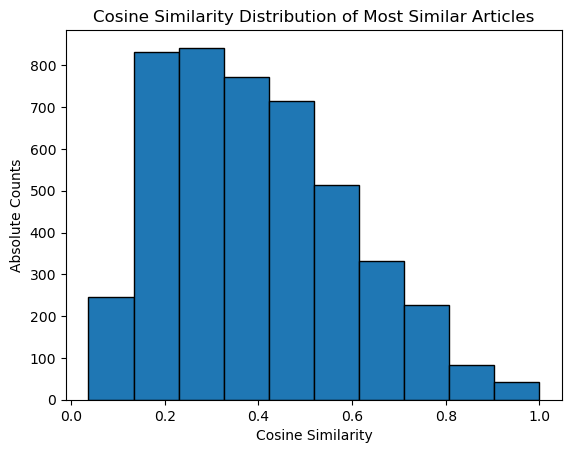

In [54]:
import matplotlib.pyplot as plt

# let's take a look at the Cosine Similarity distribution of the most similar article to a given article
most_similar = []
for idx in range(len(cosine_sim)):
    # index [-2] because index [-1] is always = 1 since it is a self similarity
    most_similar.append(sorted(cosine_sim.iloc[idx])[-2])
    
# plot the similarities
pd.Series(most_similar).plot(kind='hist', edgecolor='k')
plt.title("Cosine Similarity Distribution of Most Similar Articles")
plt.xlabel("Cosine Similarity"); plt.ylabel("Absolute Counts")

# there are no glaring red flags, e.g., most Cosine Similarities close to 0 or 1

In [55]:
# show a few concrete examples and see if our metric makes empirical sense
cosine_sim['Ukraine'].sort_values()

# results look reasonable

Primula              0.000621
Wren                 0.001130
Saxicola             0.001339
Angelica             0.001394
Nuthatch             0.001473
                       ...   
Kiev                 0.340883
History_of_Russia    0.356504
Polish-Soviet_War    0.382866
Hero_of_Ukraine      0.403438
Ukraine              1.000000
Name: Ukraine, Length: 4604, dtype: float64

In [56]:
cosine_sim['Zinc'].sort_values()
# results also look reasonable

Primula          0.000303
List_of_lakes    0.000396
Nuthatch         0.000659
Wren             0.000738
Woodpecker       0.000761
                   ...   
Metal            0.158449
Common_cold      0.222766
Cadmium          0.247857
Zinc_chloride    0.511672
Zinc             1.000000
Name: Zinc, Length: 4604, dtype: float64

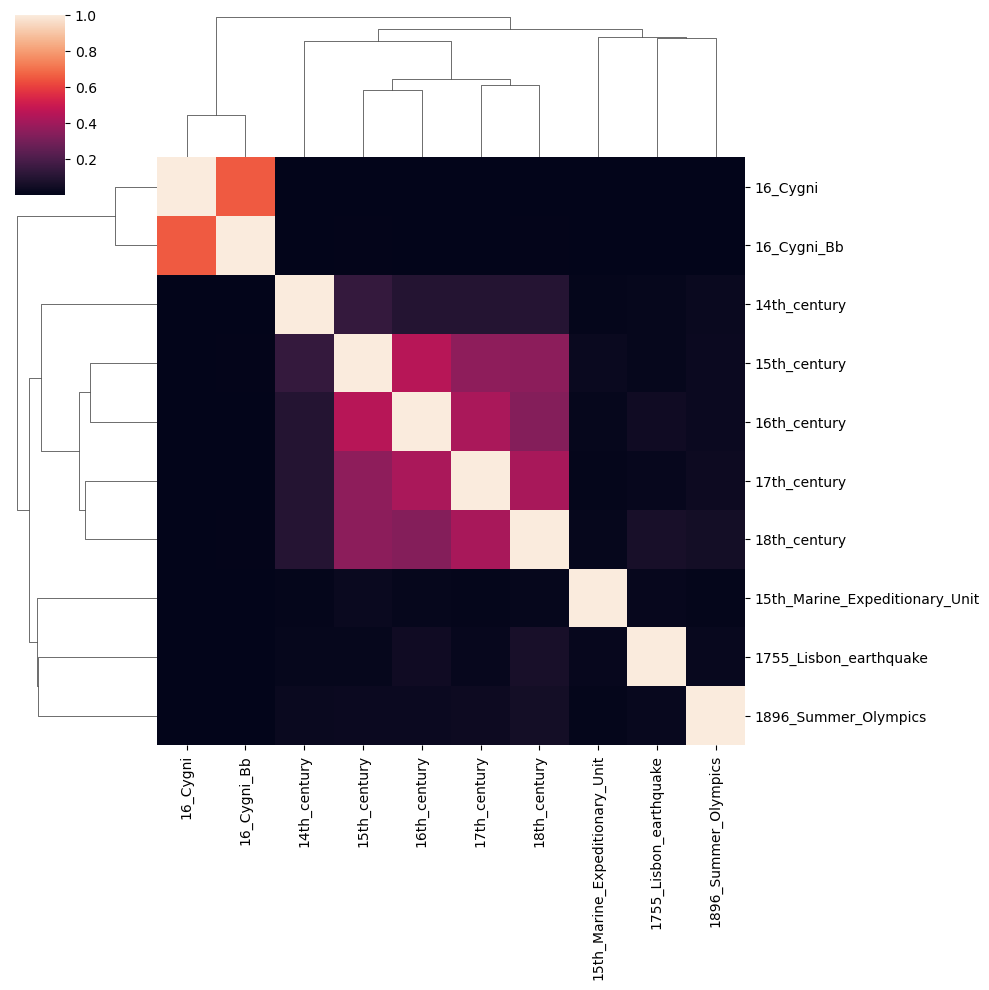

In [57]:
# "Cygni" are star systems/extrasolar planets and thus are expected to be similar
# the time periods have some similarity
sns.clustermap(cosine_sim.iloc[10:20, 10:20])

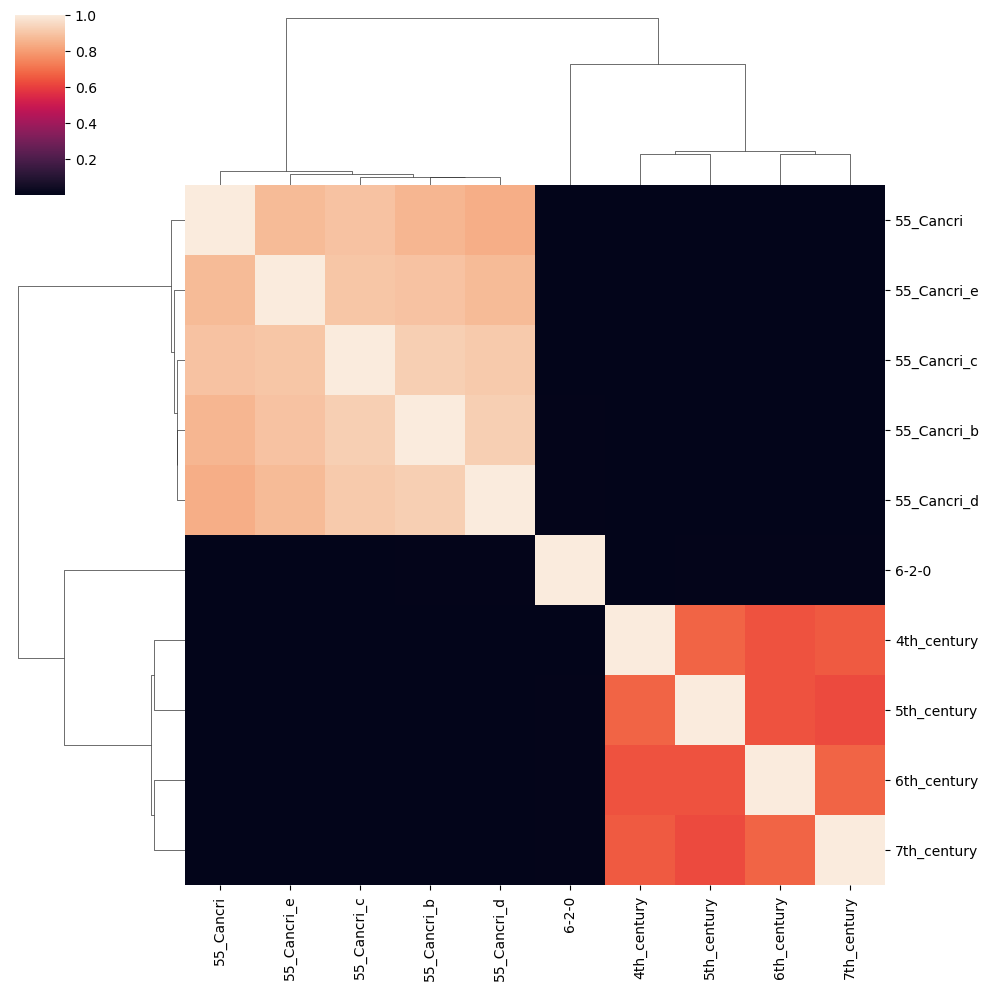

In [58]:
# "Cancri" are exoplanets and thus are expected to be similar
# we again see similarity between time periods
sns.clustermap(cosine_sim.iloc[50:60, 50:60])

In [59]:
# after confirming that the Cosine Similarity method is informative, we next show the function
# we will use to extract similarity of articles in a navigation path

# first show a hard-coded navigation path for illustration
navigation_path = '14th_century;Time;Light;Rainbow'

In [60]:
def get_path_cosine_similarity(path: str, matrix: pd.DataFrame, method: str='sequential') -> list:
    """this function takes a navigation path string and returns an array of the Cosine Similarity.
       Two methods are supported: 'sequential' (default) which measures the sequential similarity and 
       'target' which measures the similarity between the current article at the target article.
       
       Input:
       path: navigation path string
       matrix: pre-computed Cosine Similarity matrix
       method: measurement method (defaults to 'sequential')
       
       Return:
       list: list of similarity measures
    """
    
    # there is 1 article that is duplicated in the plaintext folder. Problematically, the duplicated
    # article has different names and navigation paths can point to these different names, yet the 
    # article is the same. This one exception is handled here. In the implementation, we do not have to 
    # worry about this particular article pointing back to itself as it is not possible
    
    # navigation paths are separated by ";"
    path = path.split(';')
    
    # if the path only contains the starting article, return None
    if len(path) == 1:
        return None
    
    path_sims = []
    
    def get_correct_name(query: str, base_path: str='../wikispeedia/plaintext_articles') -> str:
        """this nested function is called in case a path contains error characters.
           Returns the fixed path so it can be used to query the Cosine Similarity matrix."""
        if '_' in query and '%' not in query:
            return query
        elif query in ['Podcasting', 'Color', 'Fencing', 'Anemia', 'Quito']:
            return query
        else:
            with open(os.path.join(base_path, f'{query}.txt'), 'r') as f:
                out = f.readlines()[2].replace('\n', '')
                return out
    
    # compute the similarity between sequential nodes
    # output list length is N-1
    if method == 'sequential':
        for idx in range(0, len(path)-1, 1):
            try:
                path_sims.append(matrix.loc[path[idx]].loc[path[idx+1]])
            except Exception:
                # either path or both paths could be wrong - just "fix" both
                # treat the 1 exception due to duplicated file
                if get_correct_name(path[idx]) == 'Polish–Muscovite War (1605–1618)':
                    sim = float(cosine_sim.loc['Polish–Muscovite War (1605–1618)'].drop_duplicates()[get_correct_name(path[idx+1])])
                    path_sims.append(sim)
                    
                elif get_correct_name(path[idx+1]) == 'Polish–Muscovite War (1605–1618)':
                    sim = cosine_sim.loc[get_correct_name(path[idx])].drop_duplicates()['Polish–Muscovite War (1605–1618)']
                    path_sims.append(sim)
                    
                else:
                    path_sims.append(matrix.loc[get_correct_name(path[idx])].loc[get_correct_name(path[idx+1])])

                    
    # compute the similarity between the current node and the target node
    # output list length is N
    elif method == 'target':
        for idx in range(0, len(path), 1):
            try:
                path_sims.append(matrix.loc[path[idx]].loc[path[-1]])
            except Exception:
                # either path or both paths could be wrong - just "fix" both
                # treat the 1 exception due to duplicated file
                if get_correct_name(path[idx]) == 'Polish–Muscovite War (1605–1618)':
                    sim = cosine_sim.loc['Polish–Muscovite War (1605–1618)'].drop_duplicates()[get_correct_name(path[-1])]
                    path_sims.append(sim)
                    
                elif get_correct_name(path[-1]) == 'Polish–Muscovite War (1605–1618)':
                    sim = float(cosine_sim.loc[get_correct_name(path[idx])].drop_duplicates()['Polish–Muscovite War (1605–1618)'])
                    path_sims.append(sim)
                    
                else:
                    path_sims.append(matrix.loc[get_correct_name(path[idx])].loc[get_correct_name(path[-1])])
    
    else:
        raise ValueError('Unsupported similarity method: choose from "sequential" or "target".')
        
    return path_sims

In [61]:
# print the navigation path for reference
print(navigation_path.split(';'))

# show the "sequential" method
sequential_sims = get_path_cosine_similarity(path=navigation_path,
                                             matrix=cosine_sim,
                                             method='sequential')
# intepreted as:
# sim(14th_century, Time) = 0.031
# sim(Time, Light) = 0.147
# sim(Light, Rainbow) = 0.158
# the similarity list is always N-1 in length, N = # nodes
sequential_sims

['14th_century', 'Time', 'Light', 'Rainbow']


[0.03148221080256591, 0.14746128033868, 0.15783064270493327]

In [62]:
# show the "target" method
target_sims = get_path_cosine_similarity(path=navigation_path,
                                         matrix=cosine_sim,
                                         method='target')
# intepreted as:
# sim(14th_century, Rainbow) = 0.008
# sim(Time, Rainbow) = 0.035
# sim(Light, Rainbow) = 0.158
# sim(Rainbow, Rainbow) = 1 (the path was successful so similarity is 1)
# the similarity list is now N in length, N = # nodes

# note: paths where the last index != 1 means the path was unsuccessful
target_sims

[0.00764736982703648,
 0.03486926301697003,
 0.15783064270493327,
 1.0000000000000004]

In [63]:
# show this for the entire dataset of navigation paths
# re-use some DataFrames
# we discard navigation paths that "back track", as detailed in the first cell of this notebook
finished_paths = [path for path in paths_finished_df['path'] if '<' not in path]
unfinished_paths = [path for path in paths_unfinished_df['path'] if '<' not in path]

In [64]:
# "sequential" similarity
finished_paths_seq_sims = [get_path_cosine_similarity(path, matrix=cosine_sim) for path in finished_paths]
unfinished_paths_seq_sims = [get_path_cosine_similarity(path, matrix=cosine_sim) for path in unfinished_paths]

# "target" similarity
finished_paths_target_sims = [get_path_cosine_similarity(path, matrix=cosine_sim, method='target') for path in finished_paths]
unfinished_paths_target_sims = [get_path_cosine_similarity(path, matrix=cosine_sim, method='target') for path in unfinished_paths]


In [65]:
# print an example and check dimensions are what we expect for "sequential" similarity
print(len(finished_paths) == len(finished_paths_seq_sims))
print(f'\n{finished_paths_seq_sims[0]}')

True

[0.14347552850683373, 0.4546458558498797, 0.04310978630661858, 0.32412957255129043, 0.03354896797367541, 0.07031236029973871, 0.3571148831150812, 0.8001367430042642]


In [66]:
# next, write a function that returns whether the Cosine similarities in a navigation path are increasing/decreasing
def sims_to_bool_path(path: str):
    """this function takes a navgiation path as input and returns the path with same dimensions
       containing Booleans denoting whether the Cosine similarity is increasing"""
    # check if the path is None (occurs if the navigation path was only 1 article, i.e., the user didn't click anything)
    if path is None:
        return None
    # for the purposes of this initial investigation, assume that a path length of 1 is uninformative
    # we acknowledge that it may carry meaning,
    # for example, we would need to check if it is possible for the user to get to the target article in 1 click
    elif len(path) == 1:
        return None
    
    bool_path = []
    for idx in range(len(path)-1):
        if path[idx+1] > path[idx]:
            bool_path.append(True)
        else:
            bool_path.append(False)
    
    return bool_path
        

For an initial investigation into `Cosine Similarity based navigation`, check how many successful and unsuccesful paths contain only increasing cosine similarity.

In [67]:
# show the pipeline for just "sequential" cosine similarity, i.e., sequential article nodes

# finished paths
finished_paths_seq_bool = [sims_to_bool_path(path) for path in finished_paths_seq_sims]
# unfinished paths
unfinished_paths_seq_bool = [sims_to_bool_path(path) for path in unfinished_paths_seq_sims]

# now keep only the ones that are strictly increasing in similarity

# this function filters paths that only contain strictly increasing Cosine similarities
def filter_strictly_increasing_sims(path_list: list):
    out = [path for path in path_list if path is not None]
    out = [path for path in out if False not in path]
    
    return out

finished_paths_sim_increasing = filter_strictly_increasing_sims(finished_paths_seq_bool)
unfinished_paths_sim_increasing = filter_strictly_increasing_sims(unfinished_paths_seq_bool)

In [68]:
print(f'There are a total of {len(finished_paths_seq_bool)} successful navigation paths, of which, {len(finished_paths_sim_increasing)} ({round(len(finished_paths_sim_increasing)/len(finished_paths_seq_bool)*100)}%) have strictly increasing Cosine similarities')

print(f'There are a total of {len(unfinished_paths_seq_bool)} unsuccessful navigation paths, of which, {len(unfinished_paths_sim_increasing)} ({round(len(unfinished_paths_sim_increasing)/len(unfinished_paths_seq_bool)*100)}%) have strictly increasing Cosine similarities')

There are a total of 42323 successful navigation paths, of which, 8208 (19%) have strictly increasing Cosine similarities
There are a total of 19674 unsuccessful navigation paths, of which, 2932 (15%) have strictly increasing Cosine similarities


Based on the initial exploration in the above cell, there is a slight increase in success for paths that have strictly increasing Cosine similarity. Is this significant? This will be a question we investigate and also alternative critera for "strictly increasing". For example, what if we consider paths where we allow up to 1 decreasing Cosine similarity?

In summary, we have pre-computed a `Bag-of-Words Cosine Similarity` to quantify document similarity and the matrix is saved. Queries to the matrix are O(1). We also have functions in place that compute the Cosine similarity for all navigation paths in the dataset.

## Graph Topology

In [69]:
pd.set_option('mode.chained_assignment', None)

def str_url_format(word):
    """
    Article name preprocessing.
    
    Apply this function any time a new dataframe is loaded.
    """
    return (urllib.parse.unquote(word)
            .replace("_", " ")
            .strip()
            .lower())
    
# Graph is defined in file `links.tsv`
df_links = (pd.read_csv("../wikispeedia/wikispeedia_paths-and-graph/links.tsv", 
                        skiprows=12, 
                        sep="\t", 
                        header=None)
            .applymap(str_url_format)
            .rename(columns={0:"src",
                             1:"tgt"})
           )

df_links.sample(5)

,src,tgt
53484,hydrogen,gas giant
12821,baroque,miguel de cervantes
98487,sikhism,english language
25192,cod,norway
3793,african union,english language


In [70]:
# describe some general features of the network.

print(f"There are {df_links.shape[0]} edges")
print(f"connecting {df_links.stack().nunique()} unique nodes in the network.")
print(f"\n\t * {df_links['src'].nunique()} nodes have out-links.")
print(f"\t * {df_links['tgt'].nunique()} nodes have in-links.\n")

print(f"This means {df_links.stack().nunique() - df_links['src'].nunique()} nodes are dead-ends (no out-links),")
print(f"and {df_links.stack().nunique() - df_links['tgt'].nunique()} \
nodes can never be reached from any other article (no in-links) ☠️")

There are 119882 edges
connecting 4592 unique nodes in the network.

	 * 4587 nodes have out-links.
	 * 4135 nodes have in-links.

This means 5 nodes are dead-ends (no out-links),
and 457 nodes can never be reached from any other article (no in-links) ☠️


In [71]:
# nodes with no outlink (dead-ends).
nodes_no_outlink = (set(df_links.stack()
                    .unique())
                    .difference(df_links['src']
                    .unique()))

print(len(nodes_no_outlink))
nodes_no_outlink

5


{'directdebit',
 'duchenne muscular dystrophy',
 "klinefelter's syndrome",
 'local community',
 'osteomalacia'}

In [72]:
# let's see which articles can't be reached from any other.
nodes_no_inlink = list((set(df_links.stack()
                        .unique())
                        .difference(df_links['tgt']
                        .unique())))

print(len(nodes_no_inlink))
# these nodes can only be visited if they're selected as the starting point.
nodes_no_inlink[:5]

457


['snake charming',
 'cyril clarke',
 'templon',
 'english monarchs family tree',
 'atlantic herring']

### Describe each node.
* in-degree: How many links point to article A?

* out-degree: How many articles can be reached directly from article A?

In [73]:
freq_out = df_links['src'].value_counts()
freq_in = df_links['tgt'].value_counts()

degree_freq = (pd.merge(freq_in,
                        freq_out, 
                        left_index=True, 
                        right_index=True, 
                        how='outer')
               .fillna(0)
               .rename(columns={"src":"out",
                                "tgt":"in"}))

degree_freq.head()

,in,out
1 ceres,12.0,32.0
10th century,65.0,26.0
11th century,57.0,48.0
12th century,85.0,45.0
13th century,84.0,34.0


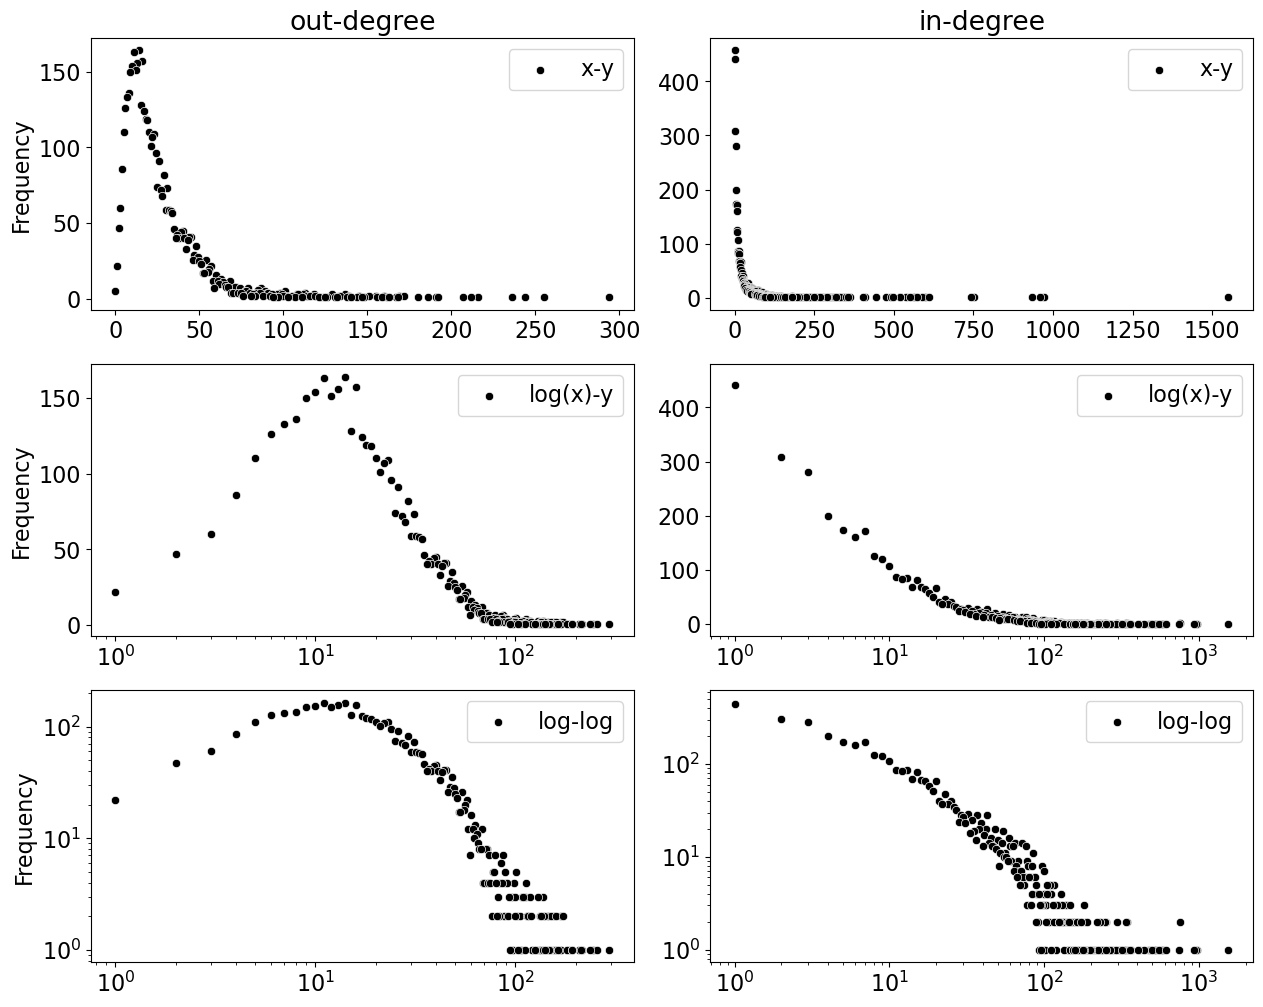

In [74]:
# check the distributions of in- and out-degree.
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(3,2,
                       figsize=(15,12),
                       gridspec_kw={'wspace':0.14})

labels = ["x-y", "log(x)-y", "log-log"]
for i in range(3):
    sns.scatterplot(data = (degree_freq['out']
                            .value_counts()), 
                    ax=ax[i,0], 
                    color='k', 
                    label=labels[i])
    sns.scatterplot(data = (degree_freq['in']
                            .value_counts()), 
                    ax=ax[i,1], 
                    color='k', 
                    label=labels[i])

ax[0, 0].set_title("out-degree")
ax[0, 1].set_title("in-degree")

for i in range(2):
    # Set log scale in x for second row plots
    ax[1,i].set_xscale('log')
    # log-log scale in 3rd row
    ax[2,i].set_xscale('log')
    ax[2,i].set_yscale('log')
    
for i in range(3):
    ax[i, 0].set_ylabel("Frequency")
    ax[i, 1].set_ylabel("")
    
plt.legend();

## Distributions of in- and out- degree are very different.
* in-degree distribution is more power-law-like. The lowest the in-degree, the higher frequency.


* out-degree has a more likely value of around 15.

In [75]:
# now let's see the clicking frequency of articles, in actual paths players took.
def split_decode_path(path):
    return list(map(
        str_url_format, 
        path.split(";")
    ))

# re-use previously initialized DataFrames for successful and unsuccessful paths
# create a "target" col
# successful paths
paths_finished_df["target"] = (paths_finished_df["path"]
                              .apply(lambda x: (str_url_format(x)
                                                .split(";")[-1])))
paths_finished_df["type"] = "win"


# Join dfs to get a full df with all paths
df_paths = pd.concat([paths_finished_df,
                      paths_unfinished_df])

# Get path list
df_paths["pathl"] = df_paths["path"].apply(split_decode_path)
# Decode target from url
df_paths["target"] = df_paths["target"].apply(str_url_format)
# Get starting node
df_paths["start"] = df_paths["pathl"].apply(lambda x:x[0])

df_paths.sample(5)

,ip,timestamp,duration,path,rating,target,type,pathl,start
17050,3bd7e1021a79dd6d,1298240279,69,18th_century;North_America;United_States;Minne...,NaN,minnesota,win,"[18th century, north america, united states, m...",18th century
20674,5b8c285f4e774708,1374568529,131,Moss;Latin;Science;Atom;Chemical_element;<;<,NaN,dysprosium,restart,"[moss, latin, science, atom, chemical element,...",moss
35333,7d5624e35c9523ef,1347645042,36,Battle_of_Gettysburg;United_States;Terrorism;O...,1.0,osama bin laden,win,"[battle of gettysburg, united states, terroris...",battle of gettysburg
2310,3f65a45346a23656,1301877999,61,Poland;United_Nations,NaN,britney spears,restart,"[poland, united nations]",poland
22862,2fae9abe1d063b1c,1380635650,207,Tornado;Italy;List_of_countries_by_system_of_g...,3.0,3 juno,win,"[tornado, italy, list of countries by system o...",tornado


In [76]:
# Merge all dfs that count node properties:
# in-degree, out-degree, use as start, use as target

from itertools import chain
degree_connect = (
    degree_freq
    .merge(
        # Count how many times an article was used as target
        df_paths["target"].value_counts(),
        left_index=True,
        right_index=True,
        how="outer"
    )
    .merge(
        # Count how many times an article was used as starting point
        df_paths["start"].value_counts(), 
        left_index=True, 
        right_index=True,
        how="outer")
    .merge(
        # Count how many times an article was clicked
        pd.Series(
            list(chain(
                *df_paths["pathl"].values
            )), 
            name="clicks"
        )
        .value_counts(), 
        left_index=True, 
        right_index=True,
        how="outer")
)

degree_connect

,in,out,target,start,clicks
1 ceres,12.0,32.0,11.0,7.0,137.0
10th century,65.0,26.0,7.0,13.0,150.0
11th century,57.0,48.0,13.0,17.0,141.0
12th century,85.0,45.0,10.0,25.0,169.0
13th century,84.0,34.0,34.0,13.0,175.0
...,...,...,...,...,...
åland,0.0,19.0,NaN,NaN,4.0
édouard manet,0.0,20.0,NaN,NaN,7.0
éire,0.0,8.0,NaN,NaN,13.0
óengus i of the picts,0.0,10.0,NaN,NaN,NaN


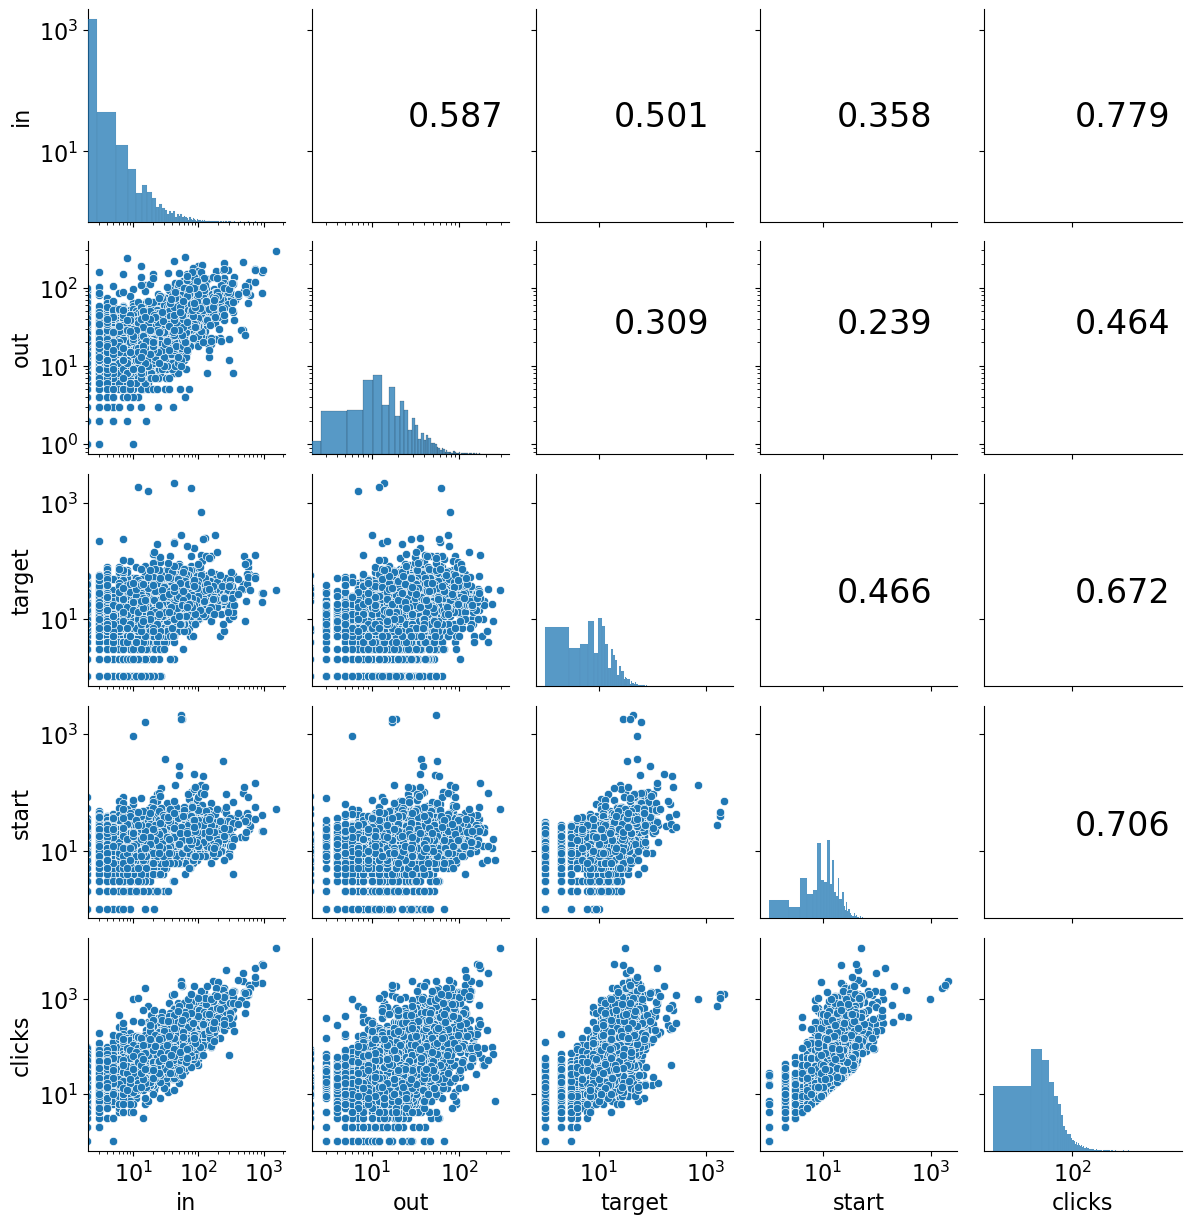

In [77]:
# Check correlation of these node-level features.
with np.errstate(divide='ignore'):
    corr = np.log(degree_connect).corr()

    
pp = sns.pairplot(degree_connect)

for i in range(5):
    for j in range(i+1,5):
        pp.axes[i,j].clear()
        
        x = degree_connect.iloc[:,j].mean()
        y = degree_connect.iloc[:,i].mean()
        pp.axes[i,j].text(x,y,
                          f"{corr.iloc[i,j]:.3f}", fontsize=24)


for ax in pp.axes.flat:
    ax.set(xscale="log", yscale="log")

# Curvature. See [1](https://match.pmf.kg.ac.rs/electronic_versions/Match80/n3/match80n3_605-622.pdf), [2](https://arxiv.org/pdf/1605.04662.pdf), and [3](https://arxiv.org/pdf/1811.07825.pdf).

## Ricci curvature: Associated with tangent vectors.

That is, a direction, so in networks it's assigned to edges (links between articles).

- Ricci curvature is weaker (than sectional curvature), but still surprisingly powerful. It measures the growth of volumes and the coupling properties of random walks

### Two types of Ricci curvature:

- Ollivier:
    Transportation distance between two points 
    Thus considers all possible paths from $x$ to $y$

- Forman:
    Riemmannian: How fast the volume of distanca ball grows.
    In networks: how fast edges spread in different directions -> notion of divergence.
        Edges with very negative curvature should play a special role for spreading out
        *they might turn out to be key for success in game* TODO: test hypothesis.
        
   For undirected, unnweighted graphs, Forman-Ricci curvature of edge $e$ is defined:
   
   $Ric(e) = 4 - deg(\nu_1) - deg(\nu_2)$
        
   - $Ric(e) << 0$      if both vertices have high degree
   - $Ric(e) = 0$       if both vertices have degree == 2.
   
   
*Let's stick to Forman-Ricci, for ease of computation and interpretability*
Empirically, both definitions highly correlate.
        
### Directed graphs.

Define $F(_\rightarrow e_\rightarrow)$ as the curvature related to flow through edge $e$.

\begin{align*}
F(_\rightarrow e_\rightarrow) &= F(_\rightarrow e) + F(e_\rightarrow) \\
F(_\rightarrow e_\rightarrow) &= 2 - in(i) - out(j)
\end{align*}

---

# For this work:

- For edges, we will quantify `flow-through`, i.e. $F(_\rightarrow e_\rightarrow)$.
- For nodes, we will quantify out-degree. This tells the potential to further connect once the node is reached.

---

Can we conclude at some point that `successful strategies are those in which a key article is first reached, and then other articles are reached from there?`.


In [78]:
degree_connect

,in,out,target,start,clicks
1 ceres,12.0,32.0,11.0,7.0,137.0
10th century,65.0,26.0,7.0,13.0,150.0
11th century,57.0,48.0,13.0,17.0,141.0
12th century,85.0,45.0,10.0,25.0,169.0
13th century,84.0,34.0,34.0,13.0,175.0
...,...,...,...,...,...
åland,0.0,19.0,NaN,NaN,4.0
édouard manet,0.0,20.0,NaN,NaN,7.0
éire,0.0,8.0,NaN,NaN,13.0
óengus i of the picts,0.0,10.0,NaN,NaN,NaN


In [79]:
# Let's calculate curvature for each edge in the graph

# get in-degree(`in`) and out-degree(`out`)
curv_edge = (df_links
             .merge((degree_connect[["in"]]
                     .rename(columns={"in":"in-degree(src)"})),
                    left_on="tgt", 
                    right_index=True,
                    how="outer")
             .merge((degree_connect[["out"]]
                     .rename(columns={"out":"out-degree(tgt)"})),
                    left_on="src", 
                    right_index=True,
                    how="outer")
            )

# Calculate curvature
curv_edge["curvature"] = 2 - curv_edge["in-degree(src)"] - curv_edge["out-degree(tgt)"]

curv_edge.sample(5)

,src,tgt,in-degree(src),out-degree(tgt),curvature
27690.0,cretaceous,tyrannosaurus,25.0,49.0,-72.0
76918.0,"nashville, tennessee",amtrak,51.0,45.0,-94.0
69984.0,mars,mars exploration rover,7.0,60.0,-65.0
115979.0,wave–particle duality,wave,30.0,25.0,-53.0
110987.0,turkey,climate,138.0,172.0,-308.0


Text(0.5, 0, 'Node out-degree')

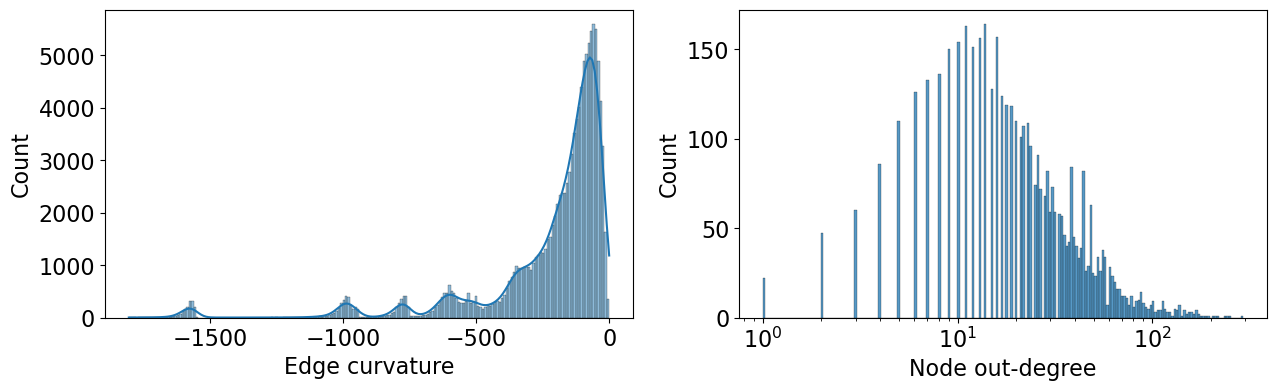

In [80]:
fig, ax = plt.subplots(1,2,figsize=(15, 4))

sns.histplot(data=curv_edge, 
             x="curvature", 
             bins=200, 
             ax=ax[0], 
             kde=True)

sns.histplot(data=degree_connect.query("out!=0"), 
             x="out", 
             bins=200, 
             ax=ax[1], 
             log_scale=True)

ax[0].set_xlabel("Edge curvature")
ax[1].set_xlabel("Node out-degree")

# Interesting.

The distribution of edge curvature seems to be centered around certain values. 
- Why? 
- How are they different? 
- Does this have any relationship with semantics?

# Let's see if paths taken by people provide some insight.

In [81]:
# First get, for every path, a sequence of nodes.

# TODO: Think abt what to do with paths containing `<`

# For convenience, let's drop them for now
df_paths_clean = (df_paths[df_paths["path"]
                           .apply(lambda x: '<' not in x)])

def list_nodes(pathl):
    return [
        [pathl[i],pathl[i+1]]
        for i in range(len(pathl)-1)
    ]
    
# Array to index edge -> curvature 
indx_curva = (curv_edge
              .set_index(["src", "tgt"])
              .loc[:,"curvature"])
def path_curvature(row):
    try:
        return (indx_curva
                .loc[row["edgel"]]
                .values)
    except:
        return []

df_paths_clean["edgel"] = df_paths_clean["pathl"].apply(list_nodes)
df_paths_clean["path_curv"] = df_paths_clean.apply(path_curvature, axis=1)

df_paths_clean.head()

,ip,timestamp,duration,path,rating,target,type,pathl,start,edgel,path_curv
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,african slave trade,win,"[14th century, 15th century, 16th century, pac...",14th century,"[[14th century, 15th century], [15th century, ...","[-129.0, -180.0, -274.0, -335.0, -130.0, -488...."
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,african slave trade,win,"[14th century, europe, africa, atlantic slave ...",14th century,"[[14th century, europe], [europe, africa], [af...","[-962.0, -634.0, -225.0, -63.0]"
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,african slave trade,win,"[14th century, niger, nigeria, british empire,...",14th century,"[[14th century, niger], [niger, nigeria], [nig...","[-94.0, -148.0, -207.0, -245.0, -577.0, -225.0..."
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,greece,win,"[14th century, renaissance, ancient greece, gr...",14th century,"[[14th century, renaissance], [renaissance, an...","[-151.0, -224.0, -309.0]"
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,john f. kennedy,win,"[14th century, italy, roman catholic church, h...",14th century,"[[14th century, italy], [italy, roman catholic...","[-579.0, -331.0, -101.0, -83.0, -250.0, -115.0]"


In [82]:
print(df_paths_clean.shape)
df_paths_clean = df_paths_clean[df_paths_clean["path_curv"].apply(len) > 0]
print(df_paths_clean.shape)

(61997, 11)
(56711, 11)


In [83]:
# plot some paths

# create columns of x values (normalized between 0 and 1)
def x_values_01(path_curv):
    return np.linspace(0,1, len(path_curv))
    
df_paths_clean['x_coord'] = (df_paths_clean['path_curv']
                             .apply(x_values_01))

#sns.lineplot(df_paths_clean['path_curv'].iloc[4])

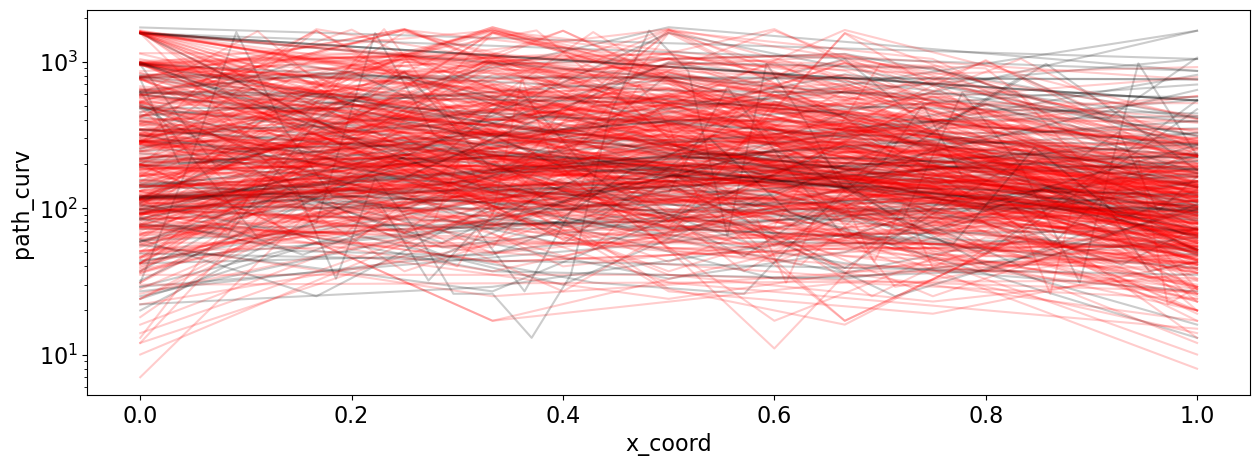

In [84]:
fig, ax = plt.subplots(figsize=(15,5))

M = 500

for i in np.random.permutation(df_paths_clean.shape[0])[:M]:
    if df_paths_clean.iloc[i]["type"] == "win":
        color='r'
    else:
        color='k'
    sns.lineplot(data = np.abs(df_paths_clean.iloc[i][['x_coord','path_curv']]), 
                 x="x_coord", y="path_curv", ax=ax,color=color, alpha=0.2)
    
ax.set_yscale('log')

# Idea:

Analyze paths by measuring the curvature of the nodes it goes through.

- Do successful paths tend to go through highly connected nodes? (we can test this statistically!)

- Can we come up with a different classification? (based on how curvature plot looks like).

TODO: Normalize x axis from 0 to 1, plot a few paths.

---

### Some articles are set as target, but are not in the graph:
Sources are: 
- misspelling (Adolf/Adolph) (Bogota/Bogotá)
- they are just not in the graph

### <font color="red"> This happens only rarely, so we'll remove these cases. </font>

In [85]:
degree_connect[degree_connect[["in","out"]].isna().any(axis=1)]

,in,out,target,start,clicks
<,NaN,NaN,NaN,NaN,33468.0
adolph hitler,NaN,NaN,1.0,NaN,NaN
black ops 2,NaN,NaN,1.0,NaN,NaN
bogota,NaN,NaN,1.0,NaN,NaN
charlottes web,NaN,NaN,1.0,NaN,NaN
christmas,NaN,NaN,5.0,NaN,NaN
english,NaN,NaN,1.0,NaN,NaN
fats,NaN,NaN,1.0,NaN,NaN
georgia,NaN,NaN,1.0,NaN,NaN
great,NaN,NaN,1.0,NaN,NaN
